In [1]:
import gradio as gr
import torch
from src.train import train
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_data(dataset):
    match dataset:
        case "Iris":
            X, y = load_iris(return_X_y=True)
            feature_names = load_iris().feature_names
        case "Wine Quality":
            X, y = load_wine(return_X_y=True)
            feature_names = load_wine().feature_names
        case "Breast Cancer":
            X, y = load_breast_cancer(return_X_y=True)
            feature_names = load_breast_cancer().feature_names
        case _:
            dataset = pd.read_csv(dataset)
            target_name = dataset.columns[-1]
            if target_name not in dataset.columns:
                raise KeyError(f"Target column '{target_name}' not found in DataFrame columns: {list(dataset.columns)}")
            y = dataset[target_name].copy()
            X = dataset.drop(columns=[target_name]).copy()
            feature_names = X.columns.tolist()
            X = X.to_numpy()
    return X, y, feature_names

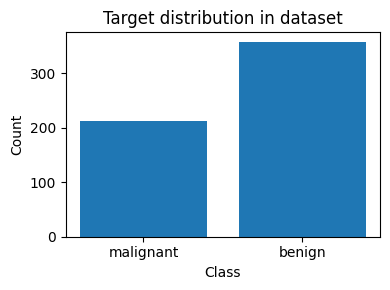

Target labels: [0 1]


wandb: Currently logged in as: lamastico2-0 (lamastico2-0-hes-so-valais-wallis) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


lr: 0.001
Epoch 01 | Loss: 0.7022 | Acc: 0.5220 | Val Loss: 0.7001 | Val Acc: 0.5439
Epoch 02 | Loss: 0.6989 | Acc: 0.5572 | Val Loss: 0.6969 | Val Acc: 0.5789
Epoch 03 | Loss: 0.6956 | Acc: 0.5718 | Val Loss: 0.6938 | Val Acc: 0.6140
Epoch 04 | Loss: 0.6924 | Acc: 0.6012 | Val Loss: 0.6909 | Val Acc: 0.6228
Epoch 05 | Loss: 0.6892 | Acc: 0.6158 | Val Loss: 0.6880 | Val Acc: 0.6228
Epoch 06 | Loss: 0.6862 | Acc: 0.6217 | Val Loss: 0.6852 | Val Acc: 0.6228
Epoch 07 | Loss: 0.6832 | Acc: 0.6246 | Val Loss: 0.6825 | Val Acc: 0.6228
Epoch 08 | Loss: 0.6804 | Acc: 0.6276 | Val Loss: 0.6799 | Val Acc: 0.6228
Epoch 09 | Loss: 0.6777 | Acc: 0.6276 | Val Loss: 0.6775 | Val Acc: 0.6228
Epoch 10 | Loss: 0.6751 | Acc: 0.6276 | Val Loss: 0.6750 | Val Acc: 0.6228
Epoch 11 | Loss: 0.6725 | Acc: 0.6276 | Val Loss: 0.6727 | Val Acc: 0.6228
Epoch 12 | Loss: 0.6699 | Acc: 0.6305 | Val Loss: 0.6703 | Val Acc: 0.6228
Epoch 13 | Loss: 0.6674 | Acc: 0.6305 | Val Loss: 0.6680 | Val Acc: 0.6228
Epoch 14 | Loss

Train Accuracy,▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇███
Train Loss,███▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
Val Accuracy,▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇█
Val Loss,███▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁
Train Accuracy,0.87097
Train Loss,0.5396
Val Accuracy,0.90351
Val Loss,0.54724


In [3]:


# Load data
X, y = load_breast_cancer(return_X_y=True)
breast = load_breast_cancer()
feature_names = breast.feature_names
target_names = breast.target_names  # typically ['malignant', 'benign']

# --- Plot target repartition BEFORE training ---
classes, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(4, 3))
plt.bar(classes, counts)
plt.xticks(classes, target_names)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Target distribution in dataset")
plt.tight_layout()
plt.show()

# --- Then train as usual ---
model, data = train(X=X, y=y, save=True, model_state=None)


In [4]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [5]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(data["X_test_tensor"])
    y_pred = (y_pred_probs > 0.5).int()

In [6]:
y_pred_np = y_pred.numpy().flatten()
y_true_np = data["y_test_tensor"].numpy().flatten()

print(classification_report(y_true_np, y_pred_np, target_names=["malignant", "benign"]))


              precision    recall  f1-score   support

   malignant       1.00      0.81      0.89        42
      benign       0.90      1.00      0.95        72

    accuracy                           0.93       114
   macro avg       0.95      0.90      0.92       114
weighted avg       0.94      0.93      0.93       114



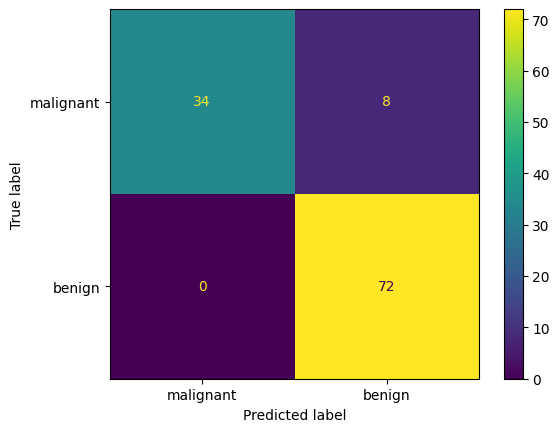

In [7]:
cm = confusion_matrix(y_true_np, y_pred_np)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["malignant", "benign"])
disp.plot()

# DEXIRE

In [8]:
from explainer.dexire import get_dexire_rules

In [9]:
rules = get_dexire_rules(model,data,feature_names=feature_names)

y_train unique values: [0 1]
class_names: ['malignant', 'benign']
11
feature_11
Symbolic expression: feature_11 <= 0.5
12
feature_12
Symbolic expression: feature_12 <= 0.5
Symbolic expression: feature_12 > 0.5
2
feature_2
Symbolic expression: feature_2 <= 0.5
15
feature_15
Symbolic expression: feature_15 <= 0.5
7
feature_7
Symbolic expression: feature_7 <= 0.5
5
feature_5
Symbolic expression: feature_5 <= 0.5
8
feature_8
Symbolic expression: feature_8 <= 0.5
Symbolic expression: feature_8 > 0.5
9
feature_9
Symbolic expression: feature_9 <= 0.5
Symbolic expression: feature_9 > 0.5
Symbolic expression: feature_5 > 0.5
Symbolic expression: feature_7 > 0.5
Symbolic expression: feature_15 > 0.5
Symbolic expression: feature_2 > 0.5
Symbolic expression: feature_11 > 0.5
27
worst_concave_points
Symbolic expression: worst_concave_points <= 0.44
6
mean_concavity
Symbolic expression: mean_concavity <= 0.775
28
worst_symmetry
Symbolic expression: worst_symmetry <= 3.039
5
mean_compactness
Symbolic

In [10]:
rules

('[IF ((worst perimeter <= 0.403) AND (mean concave points <= 0.443) AND (worst perimeter > 0.037)) THEN malignant, IF ((worst concave points <= 0.44) AND (mean concavity <= 0.775) AND (worst symmetry <= 3.039) AND (mean compactness > 0.176)) THEN malignant, IF ((worst perimeter > 0.403) AND (mean concave points > -0.111) AND (mean compactness > -0.783) AND (worst concave points > 0.57)) THEN benign, IF ((worst perimeter <= 0.403) AND (mean concave points <= 0.443) AND (worst perimeter <= 0.037) AND (worst concave points > 0.189)) THEN malignant, IF ((worst concave points > 0.44) AND (mean concave points > 0.276) AND (worst texture <= -0.281)) THEN benign, IF ((worst concave points > 0.44) AND (mean concave points > 0.276) AND (worst texture > -0.281) AND (worst compactness <= -0.329)) THEN malignant, IF ((worst concave points > 0.44) AND (mean concave points > 0.276) AND (worst texture > -0.281) AND (worst compactness > -0.329) AND (radius error > -0.442)) THEN benign, IF ((worst conc

# CIU

In [11]:
from explainer.ciu import get_explainer_CIU, get_ciu_instance
import pandas as pd

In [12]:
CIU_model = get_explainer_CIU(model, data,output_names=["malignant", "benign"], feature_names=feature_names)

In [13]:
X_test_df = pd.DataFrame(data["X_test"],  columns=feature_names)
res = get_ciu_instance(CIU_model, X_test_df.iloc[[0]])

In [14]:
display(res)

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
mean radius,0.011025,0.194159,-0.003372,malignant,0.503626,mean radius,0.501485,0.512510,[0],[0.5403961570087912],0.5,None,None
mean texture,0.004719,0.056304,-0.002094,malignant,0.503626,mean texture,0.503360,0.508079,[1],[-0.8795495788237231],0.5,None,None
mean perimeter,0.007234,0.332290,-0.001213,malignant,0.503626,mean perimeter,0.501222,0.508456,[2],[0.5697002840818889],0.5,None,None
mean area,0.042802,0.678013,0.007619,malignant,0.503626,mean area,0.474605,0.517407,[3],[0.393370381688416],0.5,None,None
mean smoothness,0.022562,0.267432,-0.005247,malignant,0.503626,mean smoothness,0.497592,0.520154,[4],[-0.10320990220203918],0.5,None,None
mean compactness,0.025682,0.309134,-0.004902,malignant,0.503626,mean compactness,0.495686,0.521369,[5],[0.6208318137765215],0.5,None,None
mean concavity,0.038177,0.475568,-0.000933,malignant,0.503626,mean concavity,0.485470,0.523647,[6],[0.3967456767175294],0.5,None,None
mean concave points,0.005889,0.910574,0.002418,malignant,0.503626,mean concave points,0.498264,0.504152,[7],[0.5543347116496173],0.5,None,None
mean symmetry,0.029344,0.459604,-0.001185,malignant,0.503626,mean symmetry,0.490139,0.519483,[8],[-0.10813593864445255],0.5,None,None
mean fractal dimension,0.018284,0.147012,-0.006454,malignant,0.503626,mean fractal dimension,0.500938,0.519221,[9],[-0.4306128036917972],0.5,None,None


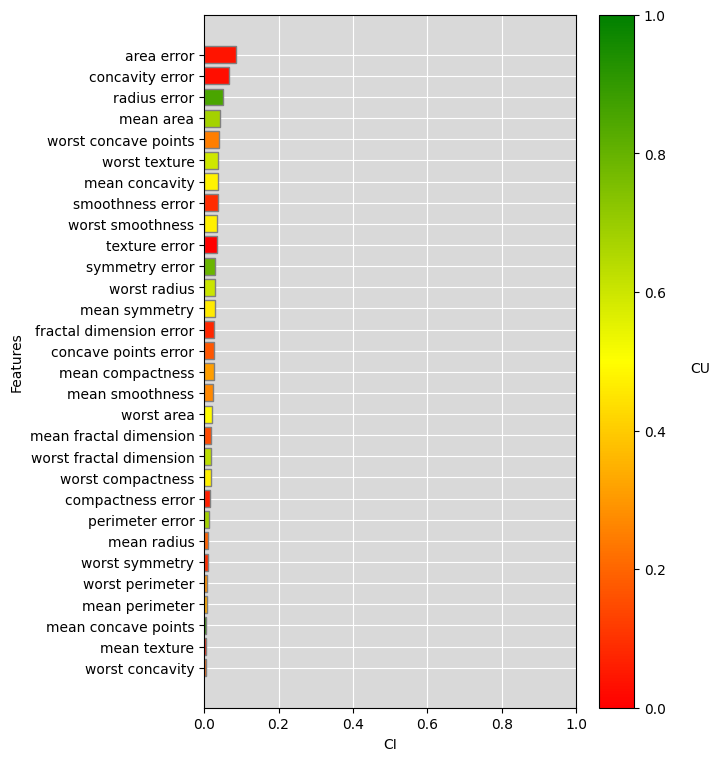

In [15]:
p = CIU_model.plot_ciu(res, figsize=(6,9))

# DEXIRE-EVO

In [16]:
from dexire_evo.ga_engine import GAEngine
from dexire_evo.rule_formatter import format_if_elif_else
from sklearn.metrics import accuracy_score, classification_report
from src.config import Config
from explainer.dexire_evo import get_dexire_evo_rules

In [17]:
best, test_acc, uncov_te, engine = get_dexire_evo_rules(feature_names, model, data)


GEN 001: fid=1.000, preds=7.0, uncov=328.0
GEN 010: fid=1.000, preds=3.0, uncov=279.0
GEN 020: fid=1.000, preds=3.0, uncov=240.0
GEN 030: fid=1.000, preds=4.0, uncov=212.0
GEN 040: fid=1.000, preds=6.0, uncov=203.0
GEN 050: fid=1.000, preds=13.0, uncov=135.0
GEN 060: fid=1.000, preds=13.0, uncov=123.0
GEN 070: fid=1.000, preds=13.0, uncov=123.0
GEN 080: fid=1.000, preds=12.0, uncov=121.0
GEN 090: fid=1.000, preds=13.0, uncov=120.0
GEN 100: fid=1.000, preds=11.0, uncov=120.0
GEN 110: fid=1.000, preds=11.0, uncov=120.0
GEN 120: fid=1.000, preds=11.0, uncov=120.0
GEN 130: fid=1.000, preds=11.0, uncov=120.0
GEN 140: fid=1.000, preds=11.0, uncov=120.0
GEN 150: fid=1.000, preds=10.0, uncov=110.0
GEN 160: fid=1.000, preds=10.0, uncov=110.0
GEN 170: fid=1.000, preds=9.0, uncov=109.0
GEN 180: fid=1.000, preds=9.0, uncov=109.0
GEN 190: fid=1.000, preds=9.0, uncov=109.0
GEN 200: fid=1.000, preds=9.0, uncov=109.0


In [18]:
print("\nRules in IF–ELIF–ELSE form (GA):")
print(format_if_elif_else(best, feature_names, engine.operator_set))


Rules in IF–ELIF–ELSE form (GA):
if mean concavity < -0.04 AND worst smoothness <= 2.66 AND radius error < 0.18: class = 1
elif worst concave points < 2.40 AND area error < 0.31 AND worst compactness < -0.14: class = 1
elif mean perimeter < -0.61: class = 1
elif radius error >= 4.28: class = 0
else symmetry error >= 2.65: class = 0


In [19]:
print("\n=== FINAL GA RESULTS ===")
print(f"Fidelity (train vs model): {best.fitness.values[0]:.3f}")
print(f"# Predicates             : {best.fitness.values[1]}")
print(f"Uncovered (train)        : {best.fitness.values[2]}")
print(f"Test accuracy (matched)  : {test_acc:.3f} | Uncov test: {uncov_te}")


=== FINAL GA RESULTS ===
Fidelity (train vs model): 1.000
# Predicates             : 9.0
Uncovered (train)        : 109.0
Test accuracy (matched)  : 0.932 | Uncov test: 40
